# Import libraries

In [1]:
import torch

import os
import random
import pandas
import numpy
from scipy.optimize import curve_fit
from torch.nn import ELU
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
# seed = 7777
# random.seed(seed) 
# torch.manual_seed(seed);

# Load Saved MP (Magnetic Parameter) Model

In [2]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
mp_model.load_state_dict(torch.load("saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [3]:
elu = ELU(0)


In [4]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        self.dense_layer3 = torch.nn.Linear(256, 512)
        self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = self.activation(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [5]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Helper functions

In [6]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [7]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()

In [8]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )
    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [9]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [10]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [11]:
def y_util(x, a, b, c):
    return (1 / (a * (x**b)))**c

In [12]:
def distance_from_origin(*args):
  distance = 0
  for objective in args:
    distance += torch.pow(objective,2)
  
  return distance

# Load DWPT data

In [13]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


In [14]:
magic_number = 10 ** (-9)

# Define Loss Functions

In [15]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    return kdiff


def calculate_Is(l_parameters, k_parameters):
  (
      k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
  ) = k_parameters
  (
      lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
      ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
      lp_1_0, ls_1_0,
  ) = l_parameters

  a6 = lp_0_0 * np ** 2
  a11 = ls_0_0 * ns ** 2
  # Paper formula
  n1 = (torch.pi * w * a6 * ip) / (2 * numpy.sqrt(2) * v_dc)
  t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(a6 * a11))
  t2 = 8 * k_0_0 * n1 * v_dc * v_bat
  n2 = t1 / t2
  Is = (4 * v_bat * n2) / (torch.pi * w * a11)

  return Is
  
def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    Is = calculate_Is(l_parameters,k_parameters)

    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    bstray = b_100

    return bstray

In [16]:
import math
f = 85*10**3 #[Hz]
w =2*math.pi*f #[rad/s]
Pout= 50000 #W
Vdc = 400 #800 # V
Vbat = 400 #V
QCoil = 400
b = 50

In [17]:
def coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters):
  (
      k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
  ) = k_parameters
  (
      lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
      ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
      lp_1_0, ls_1_0,
  ) = l_parameters
  (
      bx_p_0_00, by_p_0_00, bz_p_0_00,
      bx_p_0_90, by_p_0_90, bz_p_0_90,
      bx_s_0_00, by_s_0_00, bz_s_0_00,
      bx_s_0_90, by_s_0_90, bz_s_0_90,

      bx_p_1_00, by_p_1_00, bz_p_1_00,
      bx_p_1_90, by_p_1_90, bz_p_1_90,
      bx_s_1_00, by_s_1_00, bz_s_1_00,
      bx_s_1_90, by_s_1_90, bz_s_1_90,
  ) = b_parameters
  (
      ip, np, ns
  ) = extra_parameters


  a6 = lp_0_0 * np**2  # LP0MM_YSO
  a7 = lp_0_1 * np**2  # LP0MM_YS1
  a8 = lp_0_2 * np**2  # LP0MM_YS2
  a9 = lp_0_3 * np**2  # LP0MM_YS3
  a10 = lp_0_4 * np**2 # LP0MM_YS4

  a11 = ls_0_0 * ns**2 # LS0MM_YSO
  a12 = ls_0_1 * ns**2 # LS0MM_YS1
  a13 = ls_0_2 * ns**2 # LS0MM_YS2
  a14 = ls_0_3 * ns**2 # LS0MM_YS3
  a15 = ls_0_4 * ns**2 # LS0MM_YS4

  Is = calculate_Is(l_parameters,k_parameters)
  
  loss = (w*a6*ip**2/QCoil + w*a11*Is**2/QCoil) * 10 ** (-9)

  p0 = w*k_0_0*(a6*a11)**0.5*ip*Is
  p1 = w*k_0_1*(a7*a12)**0.5*ip*Is
  p2 = w*k_0_2*(a8*a13)**0.5*ip*Is
  p3 = w*k_0_3*(a9*a14)**0.5*ip*Is
  p4 = 2*w*k_0_4*(a10*a15)**0.5*ip*Is
  pave = (p0+(2*p1)+(2*p2)+(2*p3)+p4)/8 

  return loss,pave



In [18]:
def number_of_inverters(gp_parameters):
  (
        a, lpx, lpy, ls, p, wp, ws, *ys
  ) = gp_parameters.clone().transpose(0,1)
  number_of_inverters = 1/(lpy+2*wp+2*a+p)*10**3
  return number_of_inverters

In [19]:
  def core_losses(extra_parameters, gp_parameters):
    (
        ip, np, ns
    ) = extra_parameters

    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.transpose(0,1)
    
    V_PriCore = ((lpy +2*wp+2*a)*(lpx+2*wp+2*a)*5)/(10**3) # cm3
    V_SecCore = (((ls+2*ws+2*b)**2)*5)/(10**3)
    V_PriWind = (2*(lpx+wp)+2*(lpy+wp))*6.6*6.6/(10**3)*np
    V_SecWind = 4*(ls+ws)*6.6*6.6/(10**3)*ns

    return V_PriCore, V_SecCore, V_PriWind, V_SecWind

In [20]:
def loss_function_relu(params, max,min=False):

  relu = torch.nn.ReLU()
  return relu(params - max/torch.max(params))


In [21]:
def loss_function_power_avg(params,max_val = 30000):
  max_ = torch.max(params)
  if  max_ < max_val:
    return 0
  else:
    return max_val - max_

In [22]:
from matplotlib.patches import Rectangle

pave tensor([59810.5430, 54156.3125, 51812.8008,  ..., 45433.4961, 59664.5430,
        50916.9062], device='cuda:0', grad_fn=<DivBackward0>) tensor([1165.4009, 1224.1378, 1370.2251,  ..., 1217.0243,  854.9299,
        1251.8064], device='cuda:0', grad_fn=<MulBackward0>) tensor([37.8755, 38.5049, 40.1171,  ..., 35.3129, 32.8566, 37.9793],
       device='cuda:0', grad_fn=<PowBackward0>)
tensor(71677.2969, device='cuda:0', grad_fn=<SubBackward0>)


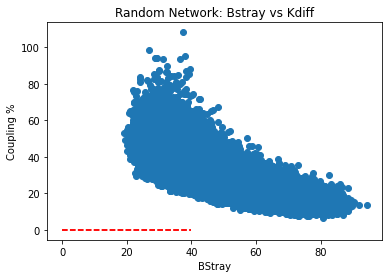

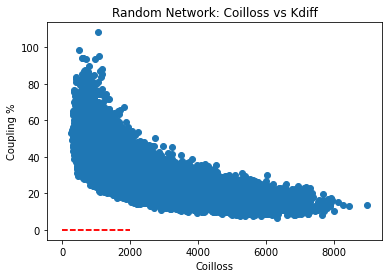

tensor([4115.6045, 3714.2214, 3452.4592,  ..., 2866.1550, 4171.8687,
        3323.7681], device='cuda:0', grad_fn=<MulBackward0>)

In [23]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)


V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters, gp_parameters)

min_x = torch.min(gp_parameters)
max_x = torch.max(gp_parameters)
gp_parameters = (gp_parameters - min_x) / (max_x - min_x)
# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)


# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
print("pave",pave,coilloss, bstray)
print(loss_function_power_avg(pave))
plt.vlines(x=40,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=.15,xmin = 0, xmax=40,color='red',linestyle='dashed')
plt.vlines(x=0,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=0,xmin = 0, xmax=40,color='red',linestyle='dashed')
#display plot
plt.scatter(bstray.detach().cpu(), 100 * kdiff.detach().cpu())
plt.title("Random Network: Bstray vs Kdiff")
plt.xlabel("BStray")
plt.ylabel("Coupling %")
plt.show()

plt.vlines(x=2000,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=.15,xmin = 0, xmax=2000,color='red',linestyle='dashed')
plt.vlines(x=0,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=0,xmin = 0, xmax=2000,color='red',linestyle='dashed')
plt.scatter(coilloss.detach().cpu(), 100 * kdiff.detach().cpu())
plt.title("Random Network: Coilloss vs Kdiff")
plt.xlabel("Coilloss")
plt.ylabel("Coupling %")
plt.show()

number_of_inverters(gp_parameters)

# Neural Network Training Loop

Epoch:    0
  Kdiff :         30.8047%
  Bstray :        49.0126
  Pave :        51389.5664
  Coilloss :        1965.7228
  Inverters :        0.6014
Epoch: 1000
  Kdiff :         36.7943%
  Bstray :        34.9666
  Pave :        117869.8594
  Coilloss :        525.4594
  Inverters :        2.5484
Epoch: 2000
  Kdiff :         33.4165%
  Bstray :        24.8237
  Pave :        3559.0347
  Coilloss :        606.3416
  Inverters :        3.0157
Epoch: 3000
  Kdiff :         29.4493%
  Bstray :        18.8230
  Pave :        6060.9756
  Coilloss :        100.7523
  Inverters :        3.3052
Epoch: 4000
  Kdiff :         28.4634%
  Bstray :        18.1424
  Pave :        12581.6143
  Coilloss :        81.1004
  Inverters :        3.2826
Epoch: 5000
  Kdiff :         27.3020%
  Bstray :        17.9611
  Pave :        -7139.4224
  Coilloss :        499.4831
  Inverters :        3.2859


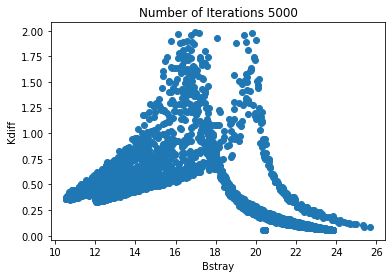

In [24]:
p_front_x = []
p_front_y = []
pareto_bstray_points = []
pareto_kdiff_points = []

kdiffs = []
bstrays = []
paves = []
coil_losses = []
vpricores = []
number_of_inverters_list = []
vsec_cores = []

i=0
combined_losses = []

for epoch in range(5001):
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(10000, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters,gp_parameters)
    new_number_of_inverters = number_of_inverters(gp_parameters)
    
    # Scale GP parameters - why?
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)
  
    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate losses
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

    coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
  
    if epoch%500 == 0:
      plt.close()
      plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())
      plt.title("Number of Iterations " + str(epoch))
      plt.xlabel("Bstray")
      plt.ylabel("Kdiff")
      plt.savefig("images/"+str(i)+".png")
      i+=1
    # Scale losses
    #distance = distance_from_origin(kdiff,bstray,coilloss, V_PriCore, V_SecCore, V_PriWind,V_SecWind) - distance_from_origin(pave)

    # distance = distance_from_origin(kdiff,bstray,coilloss) 
    # distance.mean().backward()

    new_kdiff = loss_function_relu(kdiff,.1502)
    new_bstray = loss_function_relu(bstray, 41.9)
    new_coil_loss = loss_function_relu(coilloss, 2000)
    new_pave = loss_function_power_avg(pave)
    new_number_of_inverters_ = loss_function_relu(new_number_of_inverters, 2)
    new_vsec_core = loss_function_relu(V_SecCore, 1500)


    # total_loss = torch.sum(new_kdiff*new_bstray + new_bstray*new_coil_loss + 
    #                        new_kdiff*new_coil_loss)
                          #  + new_kdiff*new_number_of_inverters_
                          #  + new_number_of_inverters_*new_bstray + new_coil_loss*new_number_of_inverters_
                          #  + new_kdiff*new_vsec_core
                          #  + new_coil_loss * new_vsec_core
                          #  + new_bstray * new_vsec_core
                          #  + new_number_of_inverters_*new_vsec_core)

    total_loss = torch.sum(new_kdiff + new_bstray + new_coil_loss + new_pave + new_number_of_inverters_ + new_vsec_core + new_pave)
    #total_loss = -torch.sum(new_pave*new_kdiff + new_pave*new_bstray + new_pave*new_coil_loss) 
    #+ torch.sum(new_kdiff*new_bstray + new_bstray*new_coil_loss + new_kdiff*new_coil_loss)

    # total_loss = torch.sum(new_bstray*new_coil_loss + 
    #                        + new_coil_loss*new_number_of_inverters_ 
    #                        + new_number_of_inverters_*new_bstray)
    total_loss.backward()
    optimizer.step()
    # Push loss through the optimizer and update the GP model
    # try:
    #     distance.backward()gp
    #     optimizer.step()
    # except Exception as e:
    #     print(f"Error on epoch {epoch} regarding", e)
    #     break

    # Log losses and other metrics
    if epoch % 1000 == 0:
        # Store metrics for plotting or further logging
        kdiffs.append(torch.mean(kdiff).cpu().data.numpy())
        bstrays.append(torch.mean(bstray).cpu().data.numpy())
        #vpricores.append(torch.mean(V_PriCore).cpu().data.numpy())
        coil_losses.append(torch.mean(coilloss).cpu().data.numpy())
        paves.append(torch.mean(pave).cpu().data.numpy())
        number_of_inverters_list.append(torch.mean(new_number_of_inverters).cpu().data.numpy())
        
        print(f"Epoch: {epoch:4d}")
        #print(f"  Combined Loss:  {combined_losses[-1]:.10f}")
        print(f"  Kdiff :         {100 * kdiffs[-1]:.4f}%")
        print(f"  Bstray :        {bstrays[-1]:.4f}")
        print(f"  Pave :        {paves[-1]:.4f}")
        print(f"  Coilloss :        {coilloss[-1]:.4f}")
        print(f"  Inverters :        {number_of_inverters_list[-1]:.4f}")
        #print(f"  VPriCore :        {vpricores[-1]:.4f}")

        # Save model for further training or testing
        #torch.save(gp_model.state_dict(), f"./models/gp_model_{epoch:06}.pt")

In [41]:
noise = generate_noise(shape=(50000, 10))
gp = gp_model(noise)proportion of the population who pass the various tests.

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
g = gp_parameters.clone()
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters,gp_parameters)
new_number_of_inverters = number_of_inverters(gp_parameters)

# Scale GP parameters - why?
min_x = torch.min(gp_parameters)
max_x = torch.max(gp_parameters)
gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)


In [ ]:
from os import walk

filenames = next(walk("images/"), (None, None, []))[2]

In [ ]:
filenames.sort(key=lambda f: int(f.split(".")[0]))

In [ ]:
with imageio.get_writer('images/mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread("images/"+filename)
        writer.append_data(image)

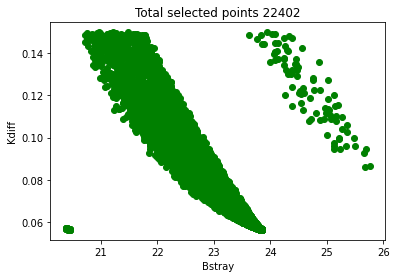

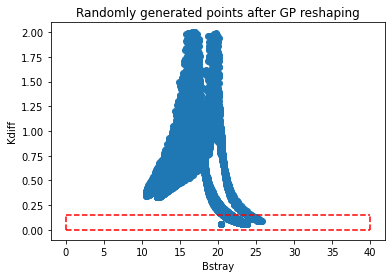

In [25]:
with torch.no_grad():
  noise = generate_noise(shape=(50000, 10))
  gp = gp_model(noise)

  # Unpack and filter GP parameters
  a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
  gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
  g = gp_parameters.clone()
  #print(gp_parameters)
  extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)
  V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters,gp_parameters)
  new_number_of_inverters = number_of_inverters(gp_parameters)
  # Scale GP parameters - why?
  min_x = torch.min(gp_parameters)
  max_x = torch.max(gp_parameters)
  gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

  # Push GP parameters through MP model
  mp_parameters = mp_model(gp_parameters)

  # Scale MP parameters
  y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
  min_y = torch.min(y, 1).values
  max_y = torch.max(y, 1).values
  mp_parameters = mp_parameters * (max_y - min_y) + min_y

  k_parameters = mp_parameters.transpose(0, 1)[0:6]
  l_parameters = mp_parameters.transpose(0, 1)[6:18]
  b_parameters = mp_parameters.transpose(0, 1)[18:]

  # Calculate losses
  kdiff = kdiff_loss(k_parameters)
  bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
  coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
  #V_PriCore, V_SecCore, V_PriWind,V_SecWind = core_losses(extra_parameters,gp_parameters)
  fig, ax = plt.subplots()
  detached_bstray = bstray.detach().cpu().numpy()
  detached_kdiff = kdiff.detach().cpu().numpy()


  new_bstray = []
  new_kdiff = []

  for i in range(len(detached_bstray)):
    if detached_bstray[i] < 40 and detached_kdiff[i] < .15:
      new_bstray.append(detached_bstray[i])
      new_kdiff.append(detached_kdiff[i])
  ax.scatter(new_bstray, new_kdiff, color='g')

  # ax.add_patch(Rectangle((0, 0), 10, 20,
  #            edgecolor = 'red',
  #            linestyle="dotted",
  #            fill=False,
  #            lw=1))
  
  plt.title("Total selected points " + str(len(new_kdiff)))
  plt.xlabel("Bstray")
  plt.ylabel("Kdiff")

  plt.show()

  plt.title("Randomly generated points after GP reshaping")
  plt.xlabel("Bstray")
  plt.ylabel("Kdiff")
  plt.vlines(x=40,ymin = 0, ymax=.15,color='red',linestyle='dashed')
  plt.hlines(y=.15,xmin = 0, xmax=40,color='red',linestyle='dashed')
  plt.vlines(x=0,ymin = 0, ymax=.15,color='red',linestyle='dashed')
  plt.hlines(y=0,xmin = 0, xmax=40,color='red',linestyle='dashed')
  plt.scatter(detached_bstray,detached_kdiff)

In [37]:
pave

tensor([-957240.6250, -484688.6250,   40041.3789,  ...,   69769.6016,
         -55574.1406,  -62896.0781], device='cuda:0')

In [26]:
fig_width = 8 #cm # Setting for Conference paper 
fig_height = 3 #cm
font_size = 7 # pt
fig_update = True
marker_size = 5
x_tick_pad = 2
y_tick_pad = 2
x_label_pad = 0.5
y_label_pad = 1

!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=fbf1780c6c038311737601f32fac5a30d1be0a7ee3d7baee98f3095704edfc40
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.reload_library()
plt.style.use(['science','no-latex'])# ref: https://github.com/garrettj403/SciencePlots 
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'}) # Update the matplotlib configuration parameters:

# distance between x and y axis and the numbers on the axes
matplotlib.rcParams['xtick.major.pad'] = x_tick_pad
matplotlib.rcParams['ytick.major.pad'] = y_tick_pad

def cm2inch(value):
    return value/2.54

def upper_right(xlim, ylim):
    x1 = np.arange(xlim,xlim*10,0.1)
    y1 = ylim
    y2 = ylim*10
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy 
    plt.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)    # draw vertical line    
    plt.plot([xlim,xlim*10], [ylim, ylim], 'r--', lw=0.5) # draw horizontal line # Ref: https://www.kite.com/python/docs/matplotlib.pyplot.fill_betwee

def upper_left(xlim, ylim):
    x1 = np.arange(0,xlim+0.1,0.1)
    y1 = ylim
    y2 = ylim*10
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line

def lower_right(xlim, ylim):
    x1 = np.arange(xlim,xlim*10,0.1)
    y1 = 0
    y2 = ylim
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([xlim,xlim*10], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line

def lower_left(xlim, ylim):
    x1 = np.arange(0,xlim+0.1,0.1)
    y1 = 0
    y2 = ylim
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line 

In [64]:
len(y)

10000

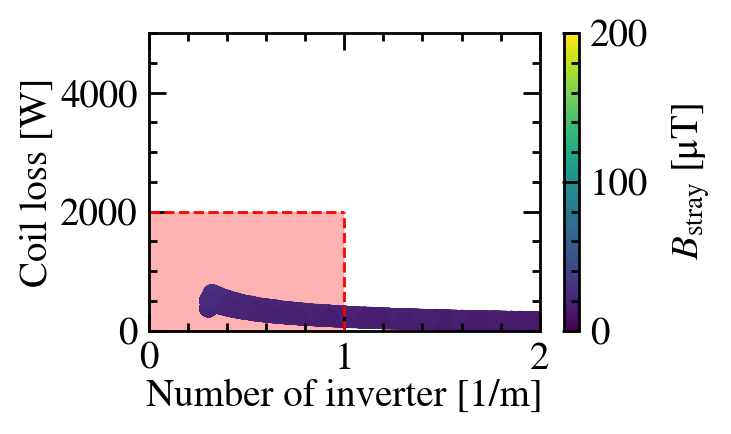

In [28]:
import matplotlib
plt.style.use(['science','no-latex'])
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
detached_bstray = bstray.detach().cpu().numpy()
detached_kdiff = kdiff.detach().cpu().numpy()
detached_coilloss = coilloss.detach().cpu().numpy()
n_inv_ = number_of_inverters(g)
n_inv_ = n_inv_.detach().cpu().numpy()
x = n_inv_
y = detached_coilloss
z = detached_bstray

fig1=plt.figure(figsize=(cm2inch(fig_width/2),cm2inch(fig_height)/1.2), dpi=400)
xlim = 1 #Number of Inverter [1/m]
ylim = 2000 #Coil loss [W] 
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=200,rasterized=True)
plt.colorbar(label=r"$B_{\rm stray}~[\rm \mu T]$")#Show colar bar at the right side 
plt.xlabel(r"Number of inverter [1/m]", labelpad = x_label_pad)              # not shown
plt.ylabel(r'Coil loss [W]', labelpad = y_label_pad) # not shown
plt.axis([0, 2, 0, 5000])   
plt.show()     

In [28]:
detached_bstray

array([43.335217, 31.312618, 45.811752, ..., 63.805637, 37.806824,
       40.38218 ], dtype=float32)

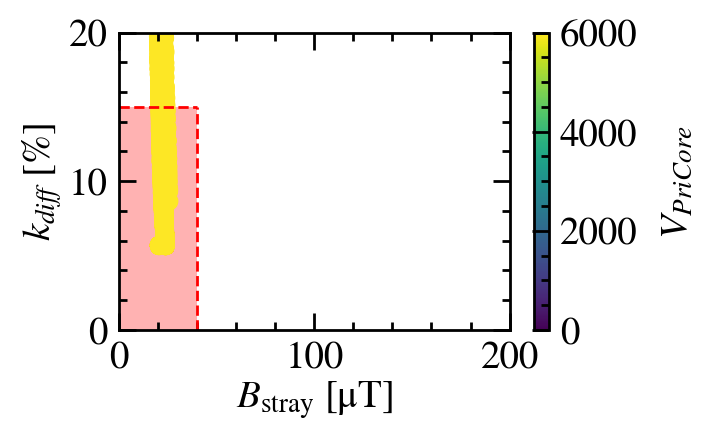

In [29]:
import matplotlib
plt.style.use(['science','no-latex'])
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
detached_bstray = bstray.detach().cpu().numpy()
detached_kdiff = kdiff.detach().cpu().numpy()*100
detached_coilloss = coilloss.detach().cpu().numpy()
v_pri_core = V_PriCore.detach().cpu().numpy()
z = v_pri_core
y = detached_kdiff
x = detached_bstray

fig1=plt.figure(figsize=(cm2inch(fig_width/2),cm2inch(fig_height)/1.2), dpi=400)
xlim = 40 #Number of Inverter [1/m]
ylim = 15 #Coil loss [W] 
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=6000,rasterized=True)
plt.colorbar(label=r"$V_{PriCore}$")#Show colar bar at the right side 
plt.xlabel(r"$B_{\rm stray}~[\rm \mu T]$", labelpad = x_label_pad)              # not shown
plt.ylabel(r'$k_{diff}$ [%]', labelpad = y_label_pad) # not shown
plt.axis([0, 200, 0, 20])   
plt.show()   

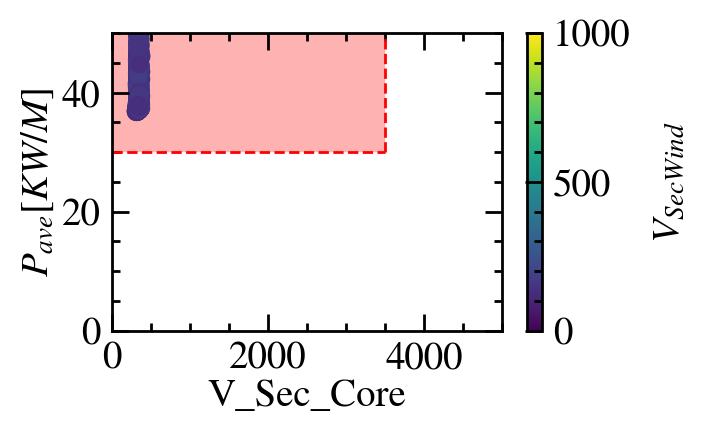

In [30]:
import matplotlib
plt.style.use(['science','no-latex'])
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
detached_pave = pave.detach().cpu().numpy()
detached_v_sec_wind = V_SecWind.detach().cpu().numpy()
v_sec_core = V_SecCore.detach().cpu().numpy()
z = detached_v_sec_wind
y = detached_pave/1000
x = v_sec_core

fig1=plt.figure(figsize=(cm2inch(fig_width/2),cm2inch(fig_height)/1.2), dpi=400)
xlim = 3500 # VPriCore[cm3]  
ylim = 30 #Pave[kW] 
upper_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=1000,rasterized=True)
plt.colorbar(label=r"$V_{SecWind}$")#Show colar bar at the right side 
plt.xlabel(r"V_Sec_Core", labelpad = x_label_pad)              # not shown
plt.ylabel(r'$P_{ave} [KW/M]$', labelpad = y_label_pad) # not shown
plt.axis([0, 5000, 0, 50])   
plt.show()  

In [46]:
V_PriCore

tensor([ 1102.1326,  1407.4108, 21091.1895,  ...,  5360.5811,    69.0551,
           95.3724], device='cuda:0')

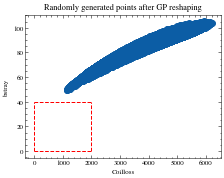

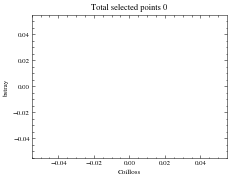

In [78]:
plt.scatter(coilloss.detach().cpu(), bstray.detach().cpu())
plt.vlines(x=2000, ymin = 0, ymax=40,color='red',linestyle='dashed')
plt.hlines(y=40,xmin = 0, xmax=2000,color='red',linestyle='dashed')
plt.vlines(x=0,ymin = 0, ymax=40,color='red',linestyle='dashed')
plt.hlines(y=0,xmin = 0, xmax=2000,color='red',linestyle='dashed')
plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Coilloss")
plt.ylabel("bstray")
plt.show()

new_coilloss = []
new_bstray = []

detached_coilloss = coilloss.detach().cpu().numpy()
detached_bstray = bstray.detach().cpu().numpy()
for i in range(len(detached_coilloss)):
  if detached_coilloss[i] < 2000 and detached_bstray[i] < 40:
    new_coilloss.append(detached_coilloss[i])
    new_bstray.append(detached_bstray[i])

plt.title("Total selected points " + str(len(new_coilloss)))
plt.xlabel("Coilloss")
plt.ylabel("bstray")
plt.scatter(new_coilloss, new_bstray, color='g')
plt.show()

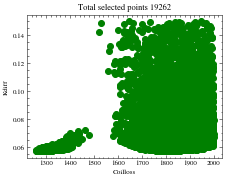

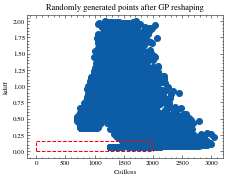

In [33]:
new_coilloss = []
new_kdiff = []

detached_coilloss = coilloss.detach().cpu().numpy()
detached_kdiff = kdiff.detach().cpu().numpy()
for i in range(len(detached_coilloss)):
  if detached_coilloss[i] < 2000 and detached_kdiff[i] < .15:
    new_coilloss.append(detached_coilloss[i])
    new_kdiff.append(detached_kdiff[i])

plt.title("Total selected points " + str(len(new_coilloss)))
plt.xlabel("Coilloss")
plt.ylabel("Kdiff")
plt.scatter(new_coilloss, new_kdiff, color='g')
plt.show()

plt.scatter(coilloss.detach().cpu(), kdiff.detach().cpu())

plt.vlines(x=2000,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=.15,xmin = 0, xmax=2000,color='red',linestyle='dashed')
plt.vlines(x=0,ymin = 0, ymax=.15,color='red',linestyle='dashed')
plt.hlines(y=0,xmin = 0, xmax=2000,color='red',linestyle='dashed')

plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Coilloss")
plt.ylabel("kdiff")
plt.show()

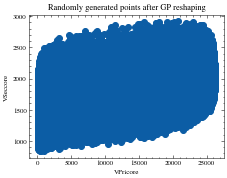

In [34]:
plt.scatter(V_PriCore.detach().cpu(), V_SecCore.detach().cpu())

plt.title("Randomly generated points after GP reshaping")
plt.xlabel("VPricore")
plt.ylabel("VSeccore")
plt.show()

# Plotting

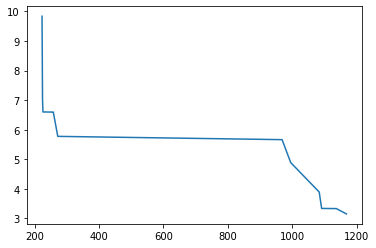

In [ ]:
noise = generate_noise(shape=(10_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
pareto_kdiff = pareto_kdiff * 100

plt.plot(pareto_bstray.detach().cpu(), pareto_kdiff.detach().cpu())

In [ ]:
200



200

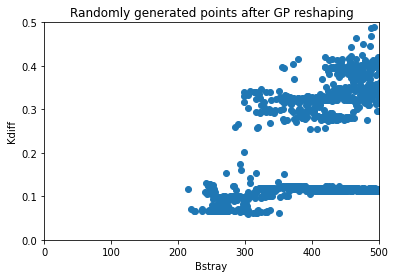

In [ ]:
noise = generate_noise(shape=(10000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
#coilloss = coil_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())

plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Bstray")
plt.ylabel("Kdiff")

plt.xlim([0,500])
plt.ylim([0,.5])
plt.show()

In [ ]:
len(bstrays)

4

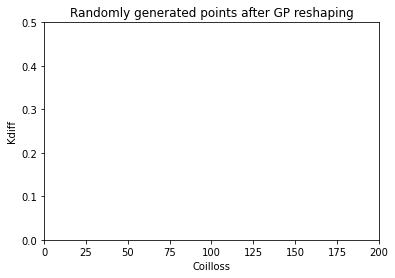

In [ ]:
coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
plt.scatter(coilloss.detach().cpu(), kdiff.detach().cpu())

plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Coilloss")
plt.ylabel("Kdiff")
plt.xlim([0,200])
plt.ylim([0,.5])
plt.show()

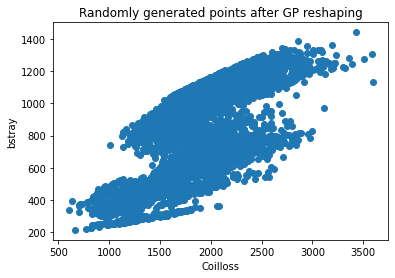

In [ ]:
plt.scatter(coilloss.detach().cpu(), bstray.detach().cpu())

plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Coilloss")
plt.ylabel("bstray")
plt.show()

In [ ]:
noise = generate_noise(shape=(3, 10))
gp = gp_model(noise)

noise = noise.cpu().numpy()
gp = gp.cpu().detach().numpy()

for i in range(3):
    print(f"Noise {i}")
    print(noise[i])
    print()
    print(f"Generated Parameters {i}")
    print(gp[i])
    print()

Noise 0
[-0.93662083  0.9035374   0.02703702 -0.79342055 -0.9278457  -0.5249814
 -0.7120999  -0.7615689  -0.43356562  0.8832253 ]

Generated Parameters 0
[0.00382875 0.94693744 0.00227757 0.14970018 0.00381177 0.00351784
 0.29845    0.01540168 0.62579644 0.3734199 ]

Noise 1
[ 0.79666936  0.4276029   0.06632411  0.034742    0.24348271  0.24962056
 -0.35332918 -0.5072838  -0.8230016   0.8600168 ]

Generated Parameters 1
[0.99724567 0.07518794 0.9988457  0.71584255 0.995408   0.99136543
 0.57148725 0.7121525  0.46268293 0.4434883 ]

Noise 2
[-0.8844336   0.4509015  -0.12377799 -0.86936617  0.62090075  0.11087704
 -0.73400044 -0.10067677 -0.9951782   0.55139136]

Generated Parameters 2
[0.68920153 0.09109823 0.44335985 0.60898614 0.679982   0.8207497
 0.32551464 0.00446921 0.44301763 0.5743412 ]



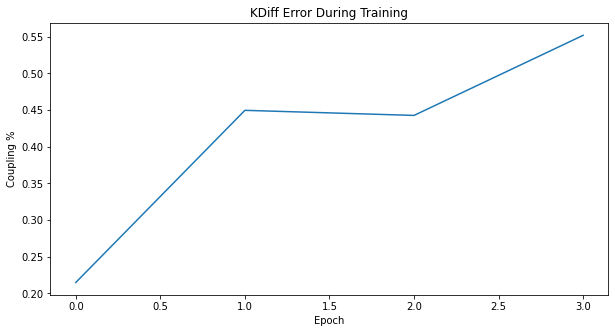

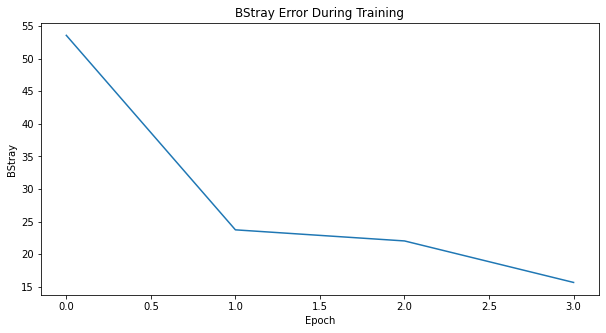

In [ ]:
plt.figure(figsize=(10, 5))
plt.title(f"KDiff Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

plt.plot(numpy.arange(len(kdiffs)), kdiffs)
plt.show()


plt.figure(figsize=(10, 5))
plt.title(f"BStray Error During Training")
plt.xlabel("Epoch")
plt.ylabel("BStray")

plt.plot(numpy.arange(len(bstrays)), bstrays)
plt.show()

0 0


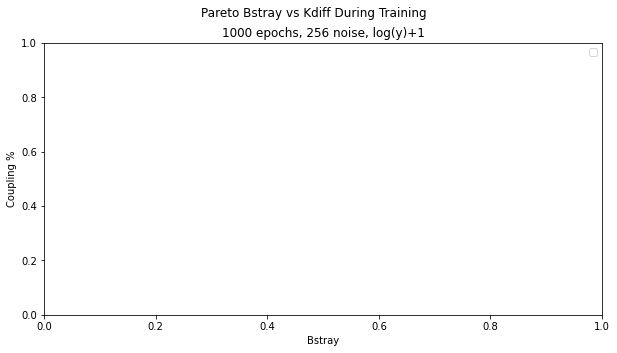

'\nplt.figure(figsize=(10, 5))\nplt.title(f"Pareto Kdiff During Training")\nplt.xlabel("Epoch")\nplt.ylabel("Coupling %")\n\nfor x in pareto_kdiff_points:\n    plt.plot(x)\nplt.show()\n'

In [ ]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title("1000 epochs, 256 noise, log(y)+1")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    i+=1
plt.legend()
plt.show()
#plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_log(y)+1.png')

'''
plt.figure(figsize=(10, 5))
plt.title(f"Pareto Kdiff During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

for x in pareto_kdiff_points:
    plt.plot(x)
plt.show()
'''

In [ ]:
print(p_front_x)

[]
